In [10]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm
from NN_Models import *

In [11]:
X_train = torch.load('data/X_author_train.pt')
X_test = torch.load('data/X_author_test.pt')
y_train = torch.load('data/y_train.pt')
y_test = torch.load('data/y_test.pt')

In [12]:
# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

100%|██████████| 100/100 [54:01<00:00, 32.42s/it]


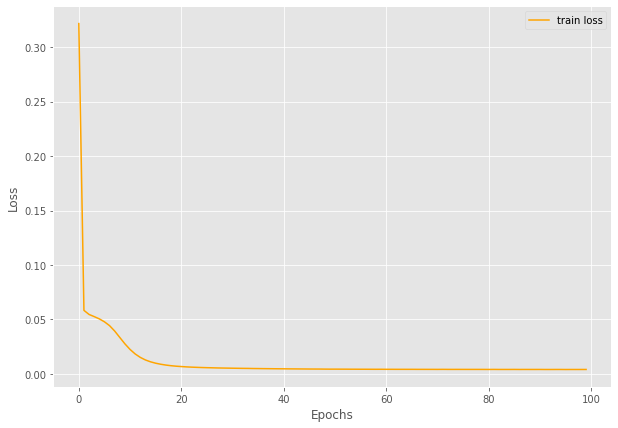

In [13]:
import torch.optim as optim

model = Model()
model.coauthor_model()

learning_rate = 0.001
optimizer = optim.Adam(params=model.coauthor_model().parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
epochs = 100
model.train(train_dataloader, optimizer, epochs)
model.save_status("coauthor")
model.plot_loss()

### Test (ignore when submit kaggle)

In [15]:
from evaluation import evaluation

# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

f1_scores = evaluation(model.model, X_test, y_test, thresholds)

[INFO]: Number of testing samples: 3086
[INFO]: Number of testing features: 21146


100%|██████████| 9/9 [03:35<00:00, 23.90s/it]


In [17]:
print(thresholds[f1_scores.index(max(f1_scores))])
print(max(f1_scores))

# print(f1_scores[thresholds.index(0.5)])

0.5
0.6143938170885868


#### 04/10
- 0.5
- 0.6075120992396789

In [18]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

# X_kaggle = for_kaggle('year_venue')

kaggle_predict(model.model, X_train, 'author_train')
kaggle_predict(model.model, X_test, 'author_test')

100%|██████████| 3086/3086 [00:13<00:00, 233.37it/s]


# Kaggle Predictions

In [9]:
from preprocessing import for_kaggle
from evaluation import kaggle_predict

X_kaggle = for_kaggle('coauthor')

kaggle_predict(model.model, X_kaggle, 'author')

100%|██████████| 800/800 [00:04<00:00, 183.04it/s]
